In [513]:
import pygsti
from pygsti.circuits import Circuit
import numpy as np
from scipy.linalg import expm, sqrtm
# import ordered dict
from collections import OrderedDict
from matplotlib import pyplot as plt
import itertools

from pygsti.modelmembers.operations import create_from_unitary_mx
from scipy.linalg import expm, logm
from pygsti.tools.jamiolkowski import jamiolkowski_iso
from pygsti.tools.basistools import change_basis
from pygsti.models import modelconstruction as _mc
import pygsti.modelmembers as _mm
from pygsti.modelmembers.operations import StaticArbitraryOp
from pygsti.processors import QubitProcessorSpec


In [514]:
def PauliMatrix(i):
    if i == 0:
        return np.array([[1, 0], [0, 1]])
    elif i == 1:
        return np.array([[0, 1], [1, 0]])
    elif i == 2:
        return np.array([[0, -1j], [1j, 0]])
    elif i == 3:
        return np.array([[1, 0], [0, -1]])
    else:
        raise ValueError("i must be 0, 1, 2, or 3.")

def PauliTensor(i, j):
    return np.kron(PauliMatrix(i), PauliMatrix(j))

single_qubit_projectors = {
    '0' : (np.eye(2) + PauliMatrix(3))/2,
    '1' : (np.eye(2) - PauliMatrix(3))/2,
    '+' : (np.eye(2) + PauliMatrix(1))/2, 
    '-' : (np.eye(2) - PauliMatrix(1))/2,
    'r' : (np.eye(2) + PauliMatrix(2))/2,
    'l' : (np.eye(2) - PauliMatrix(2))/2
}

single_qubit_meas_projector_dict = {
    'X' : [single_qubit_projectors['+'], single_qubit_projectors['-']],
    'Y' : [single_qubit_projectors['r'], single_qubit_projectors['l']],
    'Z' : [single_qubit_projectors['0'], single_qubit_projectors['1']]
}

# def prep1q_name_to_gates(prep_name):
#     if prep_name == '0':
#         return []
#     elif prep_name == '1':
#         return ['Gx']*2
#     elif prep_name == '+':
#         return ['Gy']
#     elif prep_name == '-':
#         return ['Gy']*3
#     elif prep_name == 'r':
#         return ['Gx']*3
#     elif prep_name == 'l':
#         return ['Gx']
#     else:
#         raise ValueError("prep_name must be 0, 1, +, -, r, or l.")

# def meas1q_name_to_gates(meas_name):
#     if meas_name == '0':
#         return []
#     elif meas_name == '+':
#         return ['Gy']*3
#     elif meas_name == 'r':
#         return ['Gx']
#     else:
#         raise ValueError("meas_name must be 0, +, or r.")

In [515]:
# def compile_pygsti_circ_from_prep_string(prep_string, qubit_labels):
#     num_qubits = 1
#     prep_circ = Circuit(num_qubits)
#     for i in range(num_qubits):
#         prep_circ.append((prep1q_name_to_gates(prep_string[i]), qubit_labels[i]))
#     return prep_circ

# def compile_pygsti_circ_from_meas_string(prep_string, qubit_labels):
#     num_qubits = 1
#     meas_circ = Circuit(num_qubits)
#     for i in range(num_qubits):
#         meas_circ.append((meas1q_name_to_gates(prep_string[i]), qubit_labels[i]))
#     return meas_circ
    


In [516]:
def generate_all_bit_strings(n):
    if n <= 0:
        return []

    result = ['']
    for _ in range(n):
        result = [bit_string + bit for bit_string in result for bit in ['0', '1']]

    return result

In [517]:
class ProcessTomographyExperiment:
    def __init__(self, qids, process_name='u'):
        self.process_name = process_name
        self.num_qubits = len(qids)
        self.qids = qids
        self.fiducial_dict = self._create_fiducial_dict(self.num_qubits)
        self.edesign_pygsti = self._make_pygsti_circuits(self.process_name)
        self.design_vecs = self._design_vecs()
        self.design_matrix = self._design_matrix()

    def _create_fiducial_pairs(self, num_qubits):
        all_fiducials = OrderedDict()
        all_1q_projector_labels = ['0', '1', '+', '-', 'r', 'l']
        # num_qubit-fold cartesian product of all_1q_projector_labels
        all_projector_labels = list(itertools.product(all_1q_projector_labels, repeat=num_qubits))
        for prep_fiducial in all_projector_labels:
            for meas_fiducial in all_projector_labels:
                prep_fid = 1
                meas_fid = 1
                for i in range(num_qubits):
                    prep_fid = np.kron(prep_fid, single_qubit_projectors[prep_fiducial[i]])
                    meas_fid = np.kron(meas_fid, single_qubit_projectors[meas_fiducial[i]])
                all_fiducials[''.join(prep_fiducial)+'.'+''.join(meas_fiducial)] = np.kron(prep_fid.T, meas_fid)
        return all_fiducials
    
    def _create_fiducial_dict(self, num_qubits):
        all_fiducials = {}
        all_1q_projector_labels = ['0', '1', '+', '-', 'r', 'l']
        all_1q_meas_labels = ['X', 'Y', 'Z']
        # prep: num_qubit-fold cartesian product of all_1q_projector_labels
        # meas: labelled by the projection operator of the measurement
        all_projector_labels = list(itertools.product(all_1q_projector_labels, repeat=num_qubits))
        all_meas_labels = list(itertools.product(all_1q_meas_labels, repeat=num_qubits))
        for prep_fiducial in all_projector_labels:
            all_fiducials[''.join(prep_fiducial)] = {}
            prep_fid = 1
            for i in range(num_qubits):
                prep_fid = np.kron(prep_fid, single_qubit_projectors[prep_fiducial[i]])
            for meas_fiducial in all_meas_labels:
                meas_fids = [1]*(2**num_qubits)
                for idx, bits in enumerate(generate_all_bit_strings(num_qubits)):
                    for id_b, b in enumerate(bits):
                        if b == '0':
                            meas_fids[idx] = np.kron(meas_fids[idx], single_qubit_meas_projector_dict[meas_fiducial[id_b]][0])
                        elif b == '1':
                            meas_fids[idx] = np.kron(meas_fids[idx], single_qubit_meas_projector_dict[meas_fiducial[id_b]][1])
                all_fiducials[''.join(prep_fiducial)][''.join(meas_fiducial)] = [2**num_qubits*np.kron(prep_fid, meas_fid) for meas_fid in meas_fids]
        return all_fiducials
    
    
    def prep1q_name_to_gates(self, prep_name, qid):
        if prep_name == '0':
            return Circuit()
        elif prep_name == '1':
            return Circuit([('Gxpi2', qid)])*2
        elif prep_name == '+':
            return Circuit([('Gypi2', qid)])
        elif prep_name == '-':
            return Circuit([('Gypi2', qid)])*3
        elif prep_name == 'r':
            return Circuit([('Gxpi2', qid)])*3
        elif prep_name == 'l':
            return Circuit([('Gxpi2', qid)])
        else:
            raise ValueError("prep_name must be 0, 1, +, -, r, or l.")
        
    
        
    def meas1q_name_to_gates(self, meas_name, qid):
        if meas_name == 'Z':
            return Circuit()
        elif meas_name == 'X':
            return Circuit([('Gypi2', qid)])*3
        elif meas_name == 'Y':
            return Circuit([('Gxpi2', qid)])
        else:
            raise ValueError("meas_name must be 0, +, or r.")

    def _design_vecs(self):
        vecs = OrderedDict()
        for prep_lbl in self.fiducial_dict.keys():
            for meas_lbl in self.fiducial_dict[prep_lbl].keys():
                for idx, bits in enumerate(generate_all_bit_strings(self.num_qubits)):
                    vecs[prep_lbl+'.'+meas_lbl+'.'+bits] = self.fiducial_dict[prep_lbl][meas_lbl][idx].flatten()
        return vecs
    
    def _design_matrix(self):
        return np.array([self.design_vecs[key] for key in self.design_vecs.keys()])
    
    def format_data_dict(self, data):
        formatted_data = {}
        for prep_obs in data.keys():
            for idx, bits in enumerate(generate_all_bit_strings(self.num_qubits)):
                formatted_data[prep_obs+'.'+bits] = data[prep_obs][idx]
        return formatted_data
    
    def format_dvec(self, data):
        formatted_data = self.format_data_dict(data)
        dvec = np.array([formatted_data[key] for key in self.design_vecs.keys()])
        return dvec
    
    def compile_pygsti_circ_from_prep_string(self, prep_string):
        prep_circ = Circuit(line_labels=self.qids)
        for i in range(self.num_qubits):
            c = self.prep1q_name_to_gates(prep_string[i], self.qids[i])
            prep_circ += self.prep1q_name_to_gates(prep_string[i], self.qids[i])
        return prep_circ
    
    def compile_pygsti_circ_from_meas_string(self, meas_string):
        meas_circ = Circuit(line_labels=self.qids)
        for i in range(self.num_qubits):
            meas_circ += self.meas1q_name_to_gates(meas_string[i], self.qids[i])
        return meas_circ
    
    def _make_pygsti_circuits(self, gate_label):
        # create a list of circuits
        circuits = {} 
        for prep in itertools.product(['0', '1', '+', '-', 'r', 'l'], repeat=self.num_qubits):
            for meas in itertools.product(['X', 'Y', 'Z'], repeat=self.num_qubits):
                prep_gates = self.compile_pygsti_circ_from_prep_string(prep)
                meas_gates = self.compile_pygsti_circ_from_meas_string(meas)
                key = ''.join(prep) + '.' + ''.join(meas)
                circuits[key] = Circuit(prep_gates + Circuit([['Gu', *self.qids]], line_labels=self.qids) + meas_gates)
        return circuits
    
    def get_target_model(self, gate_label, gate_unitary):
        pspec = pygsti.processors.QubitProcessorSpec(num_qubits=self.num_qubits, 
                                 gate_names=['Gi', 'Gxpi2', 'Gypi2', f'G{gate_label}'],
                                 nonstd_gate_unitaries={f'G{gate_label}': gate_unitary},
                                 availability={'Gi': [(q, ) for q in self.qids], 
                                               f'G{gate_label}': [self.qids]},
                                 qubit_labels=self.qids)
        model =  _mc.create_explicit_model(pspec)
        return model
    
    def prediction_from_choi(self, choi):
        dmat = self.design_matrix()
        return dmat@choi.flatten()

In [518]:
def vector_from_outcomes(outcomes, num_outcomes):
    """
    returns a vector from pygsti probability outcomes
    
    --- Arguments ---
    outcomes: dictionary returned by pygsti.model.probabilities 
    num_outcomes: dimension of the output hilbert space
    """
    vecout = np.zeros((num_outcomes))
    for key in outcomes.keys():
        vecout[int(key[0], 2)] = outcomes[key]
    return(vecout)

def simulate_edesign(model, edesign, num_shots, num_qubits):
    emperical_data = {}
    for lbl, circ in edesign.items():
        probs = model.probabilities(circ)
        pvec = vector_from_outcomes(probs, 2**num_qubits)
        pvec = np.clip(pvec, 0, 1)
        emperical_data[lbl] = np.random.multinomial(num_shots, pvec)/num_shots
    return emperical_data

def edesign_probabilities(choi, design_vecs):
    probs = {}
    choi_vec = choi.flatten()
    for lbl, vec in design_vecs.items():
        probs[lbl] = vec@choi_vec
    return probs

In [519]:
def random_unitary():
    phases = np.random.rand(3)*2*np.pi
    U = expm(-(1j/2)*(phases[0]*PauliMatrix(1) + phases[1]*PauliMatrix(2) + phases[2]*PauliMatrix(3)))
    return U



In [520]:
def trace_distance(A, B):
    return 0.5*np.trace(sqrtm(np.conj(A-B).T@(A-B)))

In [521]:
U = np.kron(np.eye(2), expm(-(1j/4)*np.pi*PauliMatrix(1)))
#Gu = create_from_unitary_mx(U, 'static', 'std').to_dense()

tomo = ProcessTomographyExperiment(['Q1', 'Q2'])

model = tomo.get_target_model('u', U)
edesign = tomo._make_pygsti_circuits('u')

In [522]:
print(model)

rho0 = Computational Z-basis state vec for 2 qubits w/z-values: [0 0]

Mdefault = Computational(Z)-basis POVM on 2 qubits and filter None


Gi:Q1 = 
StaticUnitaryOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0 1.00   0
   0   0   0 1.00


Gi:Q2 = 
StaticUnitaryOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0 1.00   0
   0   0   0 1.00


Gxpi2:Q1 = 
StaticUnitaryOp with shape (4, 4)
 0.71  +0j   0  +0j   0-0.71j   0  +0j
   0  +0j 0.71  +0j   0  +0j   0-0.71j
   0-0.71j   0  +0j 0.71  +0j   0  +0j
   0  +0j   0-0.71j   0  +0j 0.71  +0j


Gxpi2:Q2 = 
StaticUnitaryOp with shape (4, 4)
 0.71  +0j   0-0.71j   0  +0j   0  +0j
   0-0.71j 0.71  +0j   0  +0j   0  +0j
   0  +0j   0  +0j 0.71  +0j   0-0.71j
   0  +0j   0  +0j   0-0.71j 0.71  +0j


Gypi2:Q1 = 
StaticUnitaryOp with shape (4, 4)
 0.71   0-0.71   0
   0 0.71   0-0.71
 0.71   0 0.71   0
   0 0.71   0 0.71


Gypi2:Q2 = 
StaticUnitaryOp with shape (4, 4)
 0.71-0.71   0   0
 0.71 0.71   0   0
   0   0 0

In [523]:
data = simulate_edesign(model, edesign, 1000000000, 2)


In [524]:
formatted_data = tomo.format_data_dict(data)
dvec = tomo.format_dvec(data)

In [525]:
dmat = tomo.design_matrix
dmat_inv = np.linalg.inv(np.conj(dmat).T@dmat)@np.conj(dmat).T
choi_est = (dmat_inv@dvec).reshape(16, 16)
Gu = model.operations[('Gu', 'Q1', 'Q2')].to_dense()
Gu_std = change_basis(Gu, 'pp', 'std')
choi_true = jamiolkowski_iso(Gu_std, 'std', 'std')

In [526]:
trace_distance(choi_true, choi_est)

(1.000058814997064745+9.638250025062993829e-12j)

0.12500264642708322


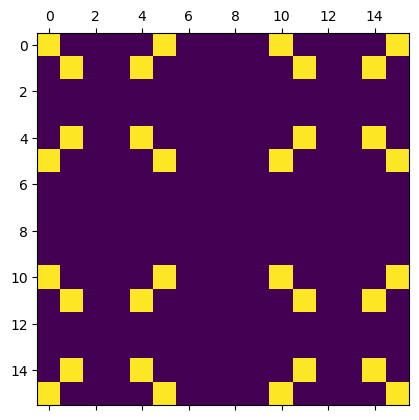

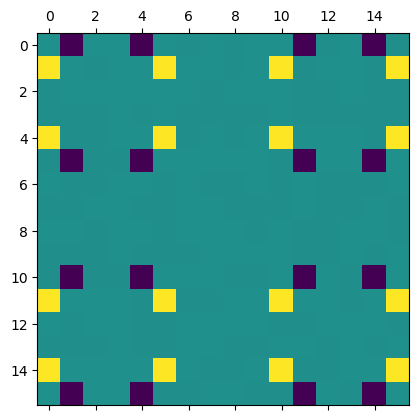

In [527]:
plt.matshow(choi_est.real)
plt.matshow(choi_est.imag)
print(np.amax(choi_est.imag))

In [528]:
np.trace(choi_est)

(0.9999999999999996+0j)

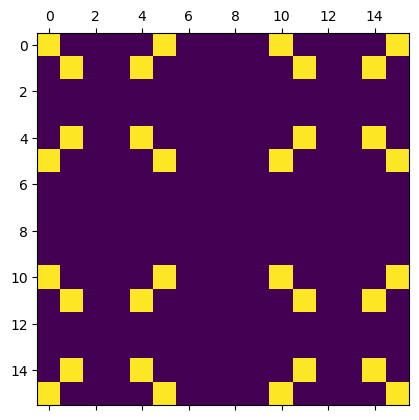

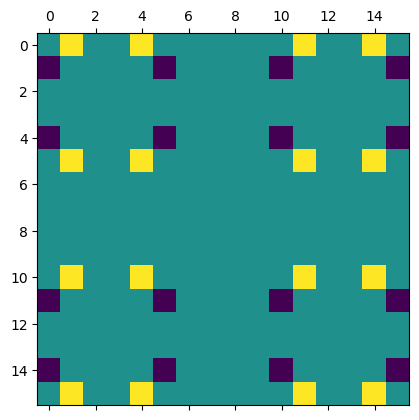

In [529]:
plt.matshow(choi_true.real)
plt.matshow(choi_true.imag)

In [530]:
choi_est.flatten()@tomo.design_vecs['00.XZ.00']

(0.2500062481620371+0j)

In [531]:
choi_true.flatten()@tomo.design_vecs['00.XZ.00']

(0.25+0j)

In [532]:
formatted_data['00.XZ.00']

0.250001129

In [533]:
tomo.design_vecs['00.XZ.00']

array([2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [534]:
E00 = np.kron(single_qubit_projectors['0'], single_qubit_projectors['0'])
rho00 = np.kron(single_qubit_projectors['0'], single_qubit_projectors['0'])
GxQ1 = model[(f'Gxpi2', 'Q1')].to_dense()

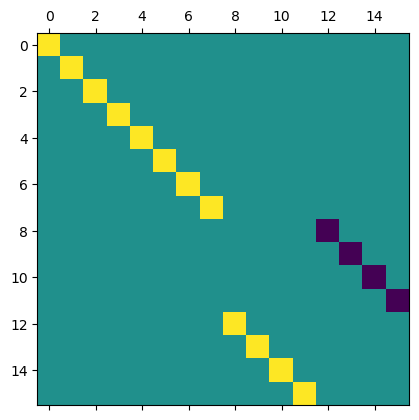

In [535]:
plt.matshow(GxQ1.real)  